# Task Overview

In this task, your goal is to verify the impact of data noise level in neural network training.
You should use MLP architecture trained on MNIST dataset (like in previous lab exercises).


We will experiment with two setups:
1. Pick X. Take X% of training examples and reassign their labels to random ones. Note that we don't change anything in the test set.
2. Pick X. During each training step, for each sample, change values of X% randomly selected pixels to random values. Note that we don't change anything in the test set.

For both setups, check the impact of various levels of noise (various values of X%) on model performance. Show plots comparing crossentropy (log-loss) and accuracy with varying X%, and also comparing two setups with each other.
Prepare short report briefly explaining the results and observed trends. Consider questions like "why accuracy/loss increases/decreases so quickly/slowly", "why Z is higher in setup 1/2" and any potentially surprising things you see on charts.

### Potential questions, clarifications
* Q: Can I still use sigmoid/MSE loss?
  * You should train your network with softmax and crossentropy loss (log-loss), especially since you should report crossentropy loss.
* Q: When I pick X% of pixels/examples, does it have to be exactly X% or can it be X% in expectation?
  * A: It's fine either way.
* Q: When I randomize pixels, should I randomize them again each time a particular example is drawn (each training step/epoch) or only once before training?
  * A: Each training step/epoch.
* Q: When I randomize labels, should I randomize them again each time a particular example is drawn (each training step/epoch) or only once before training?
  * A: Only once before training.
* Q: What is the expected length of report/explanation?
  * A: There is no minimum/maximum, but between 5 (concise) and 20 sentences should be good. Don't forget about plots.
* Q: When I replace labels/pixels with random values, what random distribution should I use?
  * A: A distribution reasonably similar to the data. However, you don't need to match dataset's distribution exactly - approximation will be totally fine, especially if it's faster or easier to get.
* Q: Can I use something different than Colab/Jupyter Notebook? E.g. just Python files.
  * A: Yes, although notebook is encouraged; please include in you solution code and pdf.

# Model definition and training.

In [1]:
import random
import numpy as np
from collections import Counter
from torchvision import datasets, transforms

# Let's read the mnist dataset

def load_mnist(path='.'):
    train_set = datasets.MNIST(path, train=True, download=True)
    x_train = train_set.data.numpy()
    _y_train = train_set.targets.numpy()
    
    test_set = datasets.MNIST(path, train=False, download=True)
    x_test = test_set.data.numpy()
    _y_test = test_set.targets.numpy()
    
    x_train = x_train.reshape((x_train.shape[0],28*28)) / 255.
    x_test = x_test.reshape((x_test.shape[0],28*28)) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [2]:
clip = 500
def sigmoid(z):
  z = np.clip(z, -clip, clip)
  return 1.0 / (1.0 + np.exp(-z))

def softmax(x):
  max_x = np.max(x, axis=0)[np.newaxis,:]
  exp_x = np.exp(x-max_x)
  return exp_x / exp_x.sum(axis=0)[np.newaxis,:]

def relu(x):
  return np.maximum(x,0)

In [7]:
class Network(object):
    def __init__(self, sizes, act_name, alpha=0.0005):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.act_name = act_name
        self.alpha = alpha

    def feedforward(self, a):
        # Run the network on a batch
        for w,b in zip(self.weights[:-1], self.biases[:-1]):
          h = np.dot(w, a) + b
          a = relu(h) if self.act_name == 'relu' else sigmoid(h)
        h = np.dot(self.weights[-1], a) + self.biases[-1]
        return h
    
    def update_mini_batch(self, x_batch, y_batch, eta):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch.
        # eta is the learning rate
        nabla_b, nabla_w = self.backprop(x_batch.T, y_batch.T)
        self.weights = [w*(1-eta*self.alpha)-(eta/len(x_batch))*nw 
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(x_batch))*nb 
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x_batch, y_batch):
        # For a single input (x,y) return a tuple of lists.
        # First contains gradients over biases, second over weights.
        
        fs = [x_batch]
        deriv_fs = []
        for w,b in zip(self.weights[:-1], self.biases[:-1]):
          h = w @ fs[-1] + b
          f = relu(h) if self.act_name == 'relu' else sigmoid(h)
          fs.append(f)
          deriv_fs.append((h>0).astype(int) \
                          if self.act_name == 'relu' else f*(1-f))

        h = np.dot(self.weights[-1], f) + self.biases[-1]
        # Now go backward from the final cost applying backpropagation
        # dLdf = dLdh
        dLdh = self.cost_derivative(h, y_batch)
        dLdhs = [dLdh.copy()]
        for w, deriv_f in reversed(list(zip(self.weights[1:],deriv_fs))):
          dLdf = w.T @ dLdh
          dLdh = dLdf * deriv_f
          dLdhs.append(dLdh)
          
        delta_nabla_w = [dLdh @ f.T for dLdh, f in zip(reversed(dLdhs),fs)] 
        delta_nabla_b = [dLdh.sum(axis=1)[:, np.newaxis] 
                         for dLdh in reversed(dLdhs)]

        return (delta_nabla_b, delta_nabla_w)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0].T),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)
    
    def cost_derivative(self, output_activations, y):
        return (softmax(output_activations)-y) 
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        raise NotImplementedError




# Training models in setup 1: with randomized labels (RL).

In [15]:
def rl(y, data_size, p):
  idxs = np.random.choice(np.arange(data_size), int(data_size*p), replace=False)
  rl = np.random.choice(np.arange(y.shape[1]), size=idxs.shape[0], replace=True)
  y[idxs] = np.eye(y.shape[1])[rl]
  print(Counter(np.argmax(y, axis=1)))
  return y

In [18]:
class Network_RL(Network):
  def __init__(self, sizes, act_name):
    super(Network_RL, self).__init__(sizes, act_name)

  def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None, p=0.1):
        x_train, y_train = training_data
        data_size = y_train.shape[0]
        for p in np.linspace(0,1,11):
          print('###', p, '###')
          y_train = rl(y_train.copy(), data_size, p)
          if test_data:
              x_test, y_test = test_data
          for j in range(epochs):
              idx = np.random.permutation(data_size)
              x_train = x_train[idx]
              y_train = y_train[idx]
              for i in range(data_size // mini_batch_size):
                  x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                  y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                  self.update_mini_batch(x_mini_batch, y_mini_batch, eta)
              if test_data:
                  print("Epoch: {0}, Accuracy: {1}".format(j, self.evaluate((x_test, y_test))))
              else:
                  print("Epoch: {0}".format(j))

network1 = Network_RL([784,30,10], act_name='sigmoid')
network1.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=1.0,\
             test_data=(x_test, y_test))


### 0.0 ###
Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})
Epoch: 0, Accuracy: 0.8811
Epoch: 1, Accuracy: 0.9084
Epoch: 2, Accuracy: 0.9303
Epoch: 3, Accuracy: 0.9353
Epoch: 4, Accuracy: 0.9441
Epoch: 5, Accuracy: 0.947
Epoch: 6, Accuracy: 0.9489
Epoch: 7, Accuracy: 0.9492
Epoch: 8, Accuracy: 0.9475
Epoch: 9, Accuracy: 0.951
Epoch: 10, Accuracy: 0.9504
Epoch: 11, Accuracy: 0.9542
Epoch: 12, Accuracy: 0.9554
Epoch: 13, Accuracy: 0.9523
Epoch: 14, Accuracy: 0.9493
Epoch: 15, Accuracy: 0.9531
Epoch: 16, Accuracy: 0.9559
Epoch: 17, Accuracy: 0.9558
Epoch: 18, Accuracy: 0.9559
Epoch: 19, Accuracy: 0.9572
### 0.1 ###
Counter({1: 6665, 7: 6228, 3: 6184, 9: 5983, 2: 5938, 0: 5936, 8: 5879, 6: 5838, 4: 5822, 5: 5527})
Epoch: 0, Accuracy: 0.9531
Epoch: 1, Accuracy: 0.9518
Epoch: 2, Accuracy: 0.9525
Epoch: 3, Accuracy: 0.9477
Epoch: 4, Accuracy: 0.9512
Epoch: 5, Accuracy: 0.9526
Epoch: 6, Accuracy: 0.9467
Epoch: 7, Accuracy: 0.9525
Epoch: 8, Ac

# Training models in setup 2: with randomized pixels. (RP)

Distribution of pixels intensity

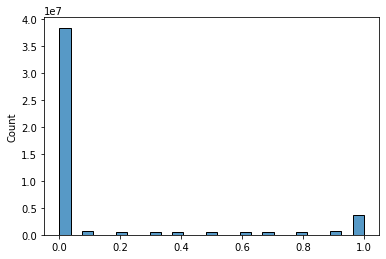

In [4]:
import seaborn as sns
x_rounded = (x_train.flatten()*10).round()/10
inten, pre_dist = zip(*Counter(x_rounded).items())
dist = np.array(pre_dist) / x_rounded.shape[0]

sns.histplot(x_rounded);

In [5]:
def rp(x, p):
  nb_pixels = x.shape[0]*x.shape[1]
  idxs = np.random.choice(np.arange(nb_pixels), int(nb_pixels*p), replace=False)
  x_flatten = x.flatten()
  x_flatten[idxs] = np.random.choice(inten, idxs.shape[0], replace=True, p=dist)
  return x_flatten.reshape(x.shape[0], x.shape[1])

In [10]:
class Network_RP(Network):
  def __init__(self, sizes, act_name, alpha=0.0005):
    super(Network_RP, self).__init__(sizes, act_name, alpha)
    self.sizes = sizes

  def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None, p=0.1):
        x_train, y_train = training_data
        data_size = y_train.shape[0]
        if test_data:
            x_test, y_test = test_data
        self.logs = {}
        for p in np.linspace(0,1,11):
          print('#####', p, '#####')
          self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
          self.weights = [np.random.randn(y, x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
          for j in range(epochs):
              idx = np.random.permutation(data_size)
              x_train = x_train[idx]
              y_train = y_train[idx]
              for i in range(data_size // mini_batch_size):
                  x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                  y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                  x_mini_batch = rp(x_mini_batch, p)
                  self.update_mini_batch(x_mini_batch, y_mini_batch, eta)

              if test_data:
                print("Epoch: {0}, Accuracy: {1}".format(j, self.evaluate((x_test, y_test))))
              else:
                print("Epoch: {0}".format(j))
              # self.logs['accuracy'] = round(self.evaluate((x_test, y_test)), 4)
              # self.logs['log loss'] = round(epoch_loss, 4)

network2 = Network_RP([784,30,10], act_name='sigmoid')
network2.SGD((x_train, y_train), epochs=30, mini_batch_size=100, eta=1.0,\
             test_data=(x_test, y_test), p=0.5)


##### 0.0 #####
Epoch: 0, Accuracy: 0.8809
Epoch: 1, Accuracy: 0.9174
Epoch: 2, Accuracy: 0.9292
Epoch: 3, Accuracy: 0.9377
Epoch: 4, Accuracy: 0.9406
Epoch: 5, Accuracy: 0.9454
Epoch: 6, Accuracy: 0.9495
Epoch: 7, Accuracy: 0.9502
Epoch: 8, Accuracy: 0.9518
Epoch: 9, Accuracy: 0.9509
Epoch: 10, Accuracy: 0.9522
Epoch: 11, Accuracy: 0.9525
Epoch: 12, Accuracy: 0.9545
Epoch: 13, Accuracy: 0.9533
Epoch: 14, Accuracy: 0.9545
Epoch: 15, Accuracy: 0.9527
Epoch: 16, Accuracy: 0.955
Epoch: 17, Accuracy: 0.9585
Epoch: 18, Accuracy: 0.9582
Epoch: 19, Accuracy: 0.9565
Epoch: 20, Accuracy: 0.9591
Epoch: 21, Accuracy: 0.9561
Epoch: 22, Accuracy: 0.9596
Epoch: 23, Accuracy: 0.9587
Epoch: 24, Accuracy: 0.9546
Epoch: 25, Accuracy: 0.9584
Epoch: 26, Accuracy: 0.9506
Epoch: 27, Accuracy: 0.9576
Epoch: 28, Accuracy: 0.9586
Epoch: 29, Accuracy: 0.9581
##### 0.1 #####
Epoch: 0, Accuracy: 0.8736
Epoch: 1, Accuracy: 0.91
Epoch: 2, Accuracy: 0.9263
Epoch: 3, Accuracy: 0.9333
Epoch: 4, Accuracy: 0.9366
Epoch:

We can observe that the efficiency of the model decreases with increasing p.